# Emitting Spot Size measurement on 2020-01-31

## Load all the data

In [1]:
import numpy as np
import pandas as pd
import pymysql
import sqlalchemy as sql
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
sns.set()
import getopt
import sys
import datetime
from scipy.interpolate import interp1d
from NGDataObject import NGDataObject
from scipy.optimize import curve_fit
from scipy import optimize

#*******************************
# CONSTANTS
#*******************************
# connection to database
CREDENTIALS_FILE = '/Users/hkromer/02_PhD/01.github/dash_NG/credentials.pw'
DB = "NG_twofast_DB" # name of the database
HOST = "twofast-RPi3-0"  # database host

# LOOKUP TABLES
LUT_PRESSURE_ION_SOURCE = "/Users/hkromer/02_PhD/01.github/phd/01_neutron_generator_contol/LUT_pressure_ion_source.txt"

### Load from stored csv files

In [2]:
path = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/DATA/emitting_spot_size_2020-01-31/'
DAY = "2020-01-31"

data_dose = pd.read_csv(f'{path}/2020-02-07_dose.csv', index_col=0)
data_dose.index = pd.to_datetime(data_dose.index)

data_hv = pd.read_csv(f'{path}/2020-02-07_hv.csv', index_col=0)
data_hv.index = pd.to_datetime(data_hv.index)

data_pressure = pd.read_csv(f'{path}/2020-02-07_pressure.csv', index_col=0)
data_pressure.index = pd.to_datetime(data_pressure.index)

data_reference_full = pd.read_csv(f'{path}/2020-02-07_reference_detectors.csv', index_col=0)
data_reference_full.index = pd.to_datetime(data_reference_full.index)

data_microwave_power_full = pd.read_csv(f'{path}/2020-02-07_microwave_power.csv', index_col=0)
data_microwave_power_full.index = pd.to_datetime(data_microwave_power_full.index)

data_microwave_frequency_full = pd.read_csv(f'{path}/2020-02-07_microwave_frequency.csv', index_col=0)
data_microwave_frequency_full.index = pd.to_datetime(data_microwave_frequency_full.index)


#### Select only relevant time

In [3]:
start = "2020-01-31 07:55:00"
end = "2020-01-31 14:45:00"

data_dose_s = data_dose.loc[start:end, ]
data_hv_s = data_hv.loc[start:end, ]
data_reference_s = data_reference_full.loc[start:end, ]


### Counts in emitting spot size detector

In [4]:
# tungsten counts
fname = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-01-31.EmittingSpot/2020-01-31_readout.csv'
data_ess = pd.read_csv(fname, index_col='time')
data_ess = data_ess[['readtime', 'value']]
data_ess.index = pd.to_datetime(data_ess.index)
# background measurement 
fname = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-01-30.EmittingSpot.Leadshield/2020-01-31_readout.csv'
data_ess_BG = pd.read_csv(fname, index_col='time')
data_ess_BG = data_ess_BG[['readtime', 'value']]
data_ess_BG.index = pd.to_datetime(data_ess_BG.index)
data_ess_BG.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1507 entries, 2020-01-30 18:47:39.153445 to 2020-01-31 07:40:25.190357
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   readtime  1507 non-null   float64
 1   value     1507 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 35.3 KB


#### Background correction of emitting spot size detector and reference detector

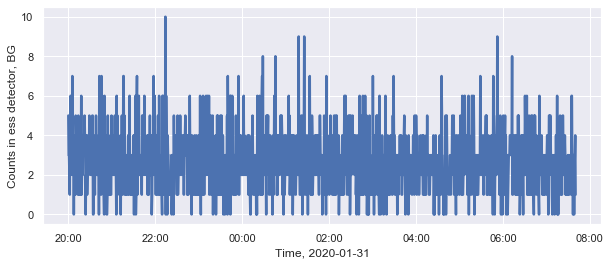

Mean background counts per 30 s interval: 2.688644688644689 1/(30s)
Mean background counts per second: 0.08905155963979494 1/s
Total counts: 3670
Total time duration: 0 days 11:40:22.783910
Total time duration: 42022 s
Total meas positions expected in that time: 1391.8256491785903 
Total measurement points: (1365, 2)
Total counts per time duration: 0.08733520536861644 1/s
Total counts per time duration error (sqrt): 0.0014416383066832574 1/s


In [5]:
start_BG = "2020-01-30 20:00:00"
end_BG = "2020-01-31 08:00:00"

data_ess_BG = data_ess_BG.loc[start_BG:end_BG, ]
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_ess_BG.index, y='value', data=data_ess_BG, ax=ax)

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Counts in ess detector, BG')
ax.set_xlabel(f'Time, {DAY}')
plt.show()
print(f"Mean background counts per 30 s interval: {data_ess_BG.value.mean()} 1/(30s)")
counting_time = data_ess_BG['readtime'].value_counts().index[0]/1000
counts_per_s_BG = data_ess_BG.value.mean()/counting_time
print(f"Mean background counts per second: {counts_per_s_BG} 1/s")
print(f"Total counts: {data_ess_BG.value.sum()}")
timedelta = data_ess_BG.index[-1]-data_ess_BG.index[0] 
print(f"Total time duration: {timedelta}")
print(f"Total time duration: {timedelta.seconds} s")
print(f"Total meas positions expected in that time: {timedelta.seconds/counting_time} ")
print(f"Total measurement points: {data_ess_BG.shape}")
counts_per_s_BG_agg = data_ess_BG.value.sum()/timedelta.seconds
counts_per_s_BG_agg_err = np.sqrt(data_ess_BG.value.sum())/timedelta.seconds
print(f"Total counts per time duration: {counts_per_s_BG_agg} 1/s")
print(f"Total counts per time duration error (sqrt): {counts_per_s_BG_agg_err} 1/s")

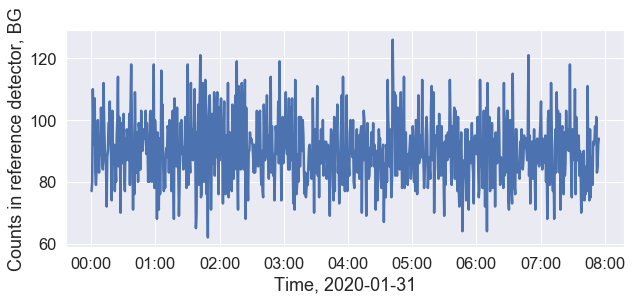

Mean background counts per 30 s interval: 90.21960297766749 1/(30s)
Mean background counts per second: 2.988195647114053 1/s
Total counts: 72717.0
Total time duration: 0 days 07:54:07.383517
Total time duration: 28447 s
Total meas positions expected in that time: 942.2032326444091 
Total measurement points: (806, 7)
Total counts per time duration: 2.5562273701972087 1/s
Total counts per time duration error (sqrt): 0.009479414285041225 1/s


In [6]:
start_BG = "2020-01-30 20:00:00"
end_BG = "2020-01-31 07:55:00"

data_ref_BG = data_reference_full.loc[start_BG:end_BG, ]
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_ref_BG.index, y='sum_counts', data=data_ref_BG, ax=ax)

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Counts in reference detector, BG')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

print(f"Mean background counts per 30 s interval: {data_ref_BG.sum_counts.mean()} 1/(30s)")
ref_counting_time = data_ref_BG['ard_time'].value_counts().index[0]/1000
ref_counts_per_s_BG = data_ref_BG.sum_counts.mean()/counting_time
print(f"Mean background counts per second: {ref_counts_per_s_BG} 1/s")
print(f"Total counts: {data_ref_BG.sum_counts.sum()}")
timedelta = data_ref_BG.index[-1]-data_ref_BG.index[0] 
print(f"Total time duration: {timedelta}")
print(f"Total time duration: {timedelta.seconds} s")
print(f"Total meas positions expected in that time: {timedelta.seconds/counting_time} ")
print(f"Total measurement points: {data_ref_BG.shape}")
ref_counts_per_s_BG_agg = data_ref_BG.sum_counts.sum()/timedelta.seconds
ref_counts_per_s_BG_agg_err = np.sqrt(data_ref_BG.sum_counts.sum())/timedelta.seconds
print(f"Total counts per time duration: {ref_counts_per_s_BG_agg} 1/s")
print(f"Total counts per time duration error (sqrt): {ref_counts_per_s_BG_agg_err} 1/s")

### Tungsten edge position

In [7]:
fname = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-01-31.EmittingSpotSize.xlsx' 
data_pos = pd.read_excel(fname, header=4)
data_pos = data_pos[['Time', 'edge_pos', 'Comment']]
data_pos = data_pos.iloc[2:,:] # clear rows at beginning and end
data_pos['edge_pos'] = data_pos['edge_pos'].astype(np.float64)
data_pos['Time'] = data_pos['Time'].apply(lambda x: f'2020-01-31 {x}')
data_pos['Time'] = pd.to_datetime(data_pos['Time'])
data_pos.set_index('Time', inplace=True, drop=True)

## Some plots - database

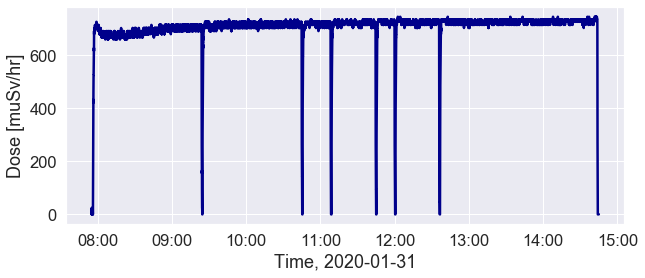

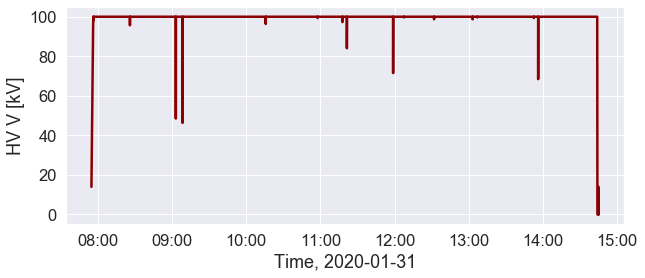

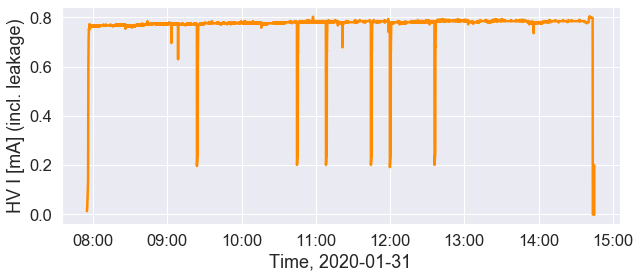

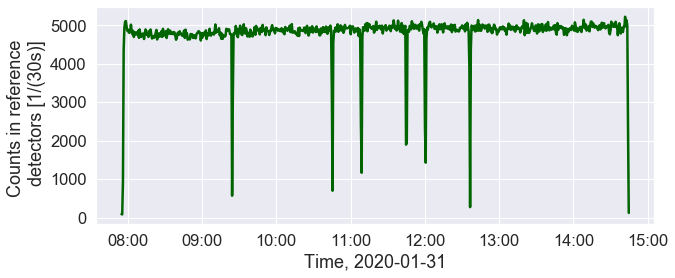

In [8]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_dose_s.index, y='dose_corrected', data=data_dose_s, ax=ax, color='darkblue')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Dose [muSv/hr]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv_s.index, y='HV_voltage', data=data_hv_s, ax=ax, color='darkred')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV V [kV]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv_s.index, y='HV_current', data=data_hv_s, ax=ax, color='darkorange')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV I [mA] (incl. leakage)')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_reference_s.index, y='sum_counts', data=data_reference_s, ax=ax, color='darkgreen')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Counts in reference \n detectors [1/(30s)]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

## ESS

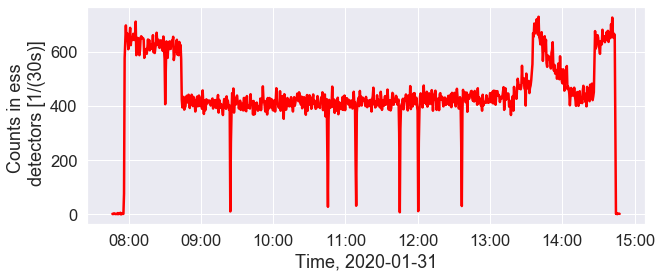

In [9]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_ess.index, y='value', data=data_ess, ax=ax, color='red')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Counts in ess \n detectors [1/(30s)]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

# Extract data for each tungsten position

### Tungsten edge position

In [10]:
fname = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-01-31.EmittingSpotSize.xlsx' 
data_pos = pd.read_excel(fname, header=4)
data_pos = data_pos[['Time', 'edge_pos', 'Comment', 'analysis']]
data_pos = data_pos.iloc[2:,:] # clear rows at beginning and end
data_pos['edge_pos'] = data_pos['edge_pos'].astype(np.float64)
data_pos['Time'] = data_pos['Time'].apply(lambda x: f'2020-01-31 {x}')
data_pos['Time'] = pd.to_datetime(data_pos['Time'])
data_pos.set_index('Time', inplace=True, drop=True)
data_pos = data_pos[data_pos['analysis'] != 'remove']

## Adjust times using analysis column

In [11]:
# get the new time from the excel
data_pos_mod = data_pos[data_pos['analysis'].notnull()]
data_pos_mod.loc[:, 'analysis'] = data_pos_mod.loc[:, 'analysis'].apply(lambda x: f'2020-01-31 {x}')
data_pos_mod.loc[:, 'new_time'] = pd.to_datetime(data_pos_mod.loc[:,'analysis'])
# create dictionary for replacement
data_pos_mod = data_pos_mod[['new_time']]
dict_replace = data_pos_mod.to_dict()['new_time']

/Users/hkromer/anaconda3/envs/py3.7/lib/python3.8/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/hkromer/anaconda3/envs/py3.7/lib/python3.8/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [12]:
# replace the column
data_pos['time'] = data_pos.index
data_pos['time'] = data_pos['time'].replace(dict_replace)
# make it new index
data_pos = data_pos.set_index('time', drop=True)
data_pos = data_pos[['edge_pos']]
data_pos['t0'] = data_pos.index
data_pos['t1'] = data_pos['t0'].shift(-1)

In [13]:
# replace in t0
dict_replace = {
    pd.Timestamp('2020-01-31 13:52:00'): pd.Timestamp('2020-01-31 13:52:30'),
    pd.Timestamp('2020-01-31 14:26:00'): pd.Timestamp('2020-01-31 14:28:00')
    
}
data_pos['t0'] = data_pos['t0'].replace(dict_replace)

# replace in t1
dict_replace = {
    pd.Timestamp('2020-01-31 08:45:00'): pd.Timestamp('2020-01-31 08:43:00'),
    pd.Timestamp('2020-01-31 13:36:00'): pd.Timestamp('2020-01-31 13:35:00')
}
data_pos['t1'] = data_pos['t1'].replace(dict_replace)

In [14]:
# remove first last time

# loop through edge position
ii = 0
for ii in range(0,data_pos.shape[0]):

    # get the beginning and end time, t0 and t1
    t0 = data_pos.iloc[ii, :].loc['t0']
    t1 = data_pos.iloc[ii, :].loc['t1']
    pos = data_pos.iloc[ii, :].loc['edge_pos'] # mm
    ess_counts = data_ess[(data_ess.index >= t0) & (data_ess.index <= t1)].loc[:,'value']

    counts_max = ess_counts.max()
    counts_min = ess_counts.min()
    counts_std = ess_counts.std()
    
    if len(ess_counts)>0:

        print(f"{counts_max:.2f}, {counts_min:.2f}, {counts_std:.2f}")
        # check the counts in the ess detector, when not significantly change
#         fig, ax = plt.subplots(figsize=(8,3))
#         sns.set()
#         sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
#         sns.lineplot(x=ess_counts.index, y=ess_counts, ax=ax)
#         ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
#         ax.set_ylabel('Counts in ess \n detectors [1/(30s)]')
#         ax.set_xlabel(f'Time, {DAY}')
#         plt.title(f"{t0} \n {t1}")
#         plt.show()
    else:
        print(f"No data for ii {ii} t0 {t0} t1 {t1}")



712.00, 588.00, 29.69
658.00, 578.00, 26.62
671.00, 596.00, 19.32
656.00, 407.00, 48.06
442.00, 387.00, 18.73
458.00, 371.00, 20.56
441.00, 367.00, 16.96
465.00, 11.00, 86.97
444.00, 369.00, 21.74
473.00, 369.00, 22.34
466.00, 353.00, 24.11
451.00, 380.00, 18.59
443.00, 368.00, 20.50
472.00, 28.00, 79.98
456.00, 32.00, 74.02
468.00, 380.00, 17.63
461.00, 386.00, 19.80
449.00, 8.00, 90.39
474.00, 12.00, 83.80
476.00, 395.00, 22.23
457.00, 383.00, 19.84
464.00, 391.00, 20.35
460.00, 31.00, 83.21
466.00, 383.00, 17.33
457.00, 405.00, 15.72
471.00, 367.00, 28.06
549.00, 402.00, 28.44
730.00, 655.00, 26.22
673.00, 567.00, 30.94
645.00, 539.00, 29.77
557.00, 499.00, 18.73
584.00, 457.00, 35.38
548.00, 403.00, 40.40
468.00, 401.00, 21.43
475.00, 411.00, 21.16
483.00, 399.00, 25.69
662.00, 613.00, 20.95
682.00, 593.00, 22.91
727.00, 637.00, 27.48
No data for ii 39 t0 2020-01-31 14:43:00 t1 NaT


### Bring all data sources on the same timestamp and join them

In [15]:
def resample_30_seconds(df, cols, range_start, range_end):
    """
    Takes the a grouped df (grouped by day) and resamples the columns cols in 10s
    OUTPUT:
        - dataframe
    """

    d = {}

    s = pd.date_range(start=range_start, end=range_end, freq='30S')
    df_out = pd.DataFrame(pd.Series(s, name='time')).set_index('time')
    for col in cols:
        d[col] = df[col].resample('30S').mean()

    this_d = pd.DataFrame(d)

    df_out = df_out.merge(this_d, left_on=df_out.index, right_on=this_d.index, how='outer')
    df_out = df_out.set_index('key_0')
    df_out.index.name ='time'    
    
    return df_out


In [16]:
data_ess.head()

,readtime,value
time,,
2020-01-31 07:46:32.274464,30192.0,2
2020-01-31 07:47:02.852278,30192.0,1
2020-01-31 07:47:33.432551,30192.0,3
2020-01-31 07:48:04.027681,30192.0,4
2020-01-31 07:48:34.605620,30192.0,2


In [17]:
data = resample_30_seconds(data_dose_s, ['dose_corrected'], start, end)
data = pd.merge(data, resample_30_seconds(data_hv_s, ['HV_voltage', 'HV_current'], start, end), left_index=True, right_index=True)
data = pd.merge(data, resample_30_seconds(data_reference_s, ['sum_counts'], start, end), left_index=True, right_index=True)
data = pd.merge(data, resample_30_seconds(data_ess, ['value'], start, end), left_index=True, right_index=True)

data = data.rename({'value': 'ESS_cnt', 'sum_counts': "REF_cnt", "dose_corrected": "DOSE", "HV_voltage": "HV_V", "HV_current": "HV_I"}, axis='columns')
data.to_csv(f'{path}/data_same_time.csv')
data.head()

,DOSE,HV_V,HV_I,REF_cnt,ESS_cnt
time,,,,,
2020-01-31 07:55:00,8.388433,28.421217,0.036468,89.0,2.0
2020-01-31 07:55:30,11.570711,58.441683,0.143207,82.0,2.0
2020-01-31 07:56:00,180.510610,88.322943,0.650083,937.0,77.0
2020-01-31 07:56:30,569.249172,99.935962,0.751034,4362.0,577.0
2020-01-31 07:57:00,687.727500,100.000000,0.756148,4936.0,633.0


In [18]:
data_pos.head()

,edge_pos,t0,t1
time,,,
2020-01-31 07:57:00,25.0,2020-01-31 07:57:00,2020-01-31 08:07:00
2020-01-31 08:07:00,23.0,2020-01-31 08:07:00,2020-01-31 08:17:00
2020-01-31 08:17:00,21.0,2020-01-31 08:17:00,2020-01-31 08:29:00
2020-01-31 08:29:00,19.0,2020-01-31 08:29:00,2020-01-31 08:43:00
2020-01-31 08:45:00,17.0,2020-01-31 08:45:00,2020-01-31 08:54:00


### Get relevant data for the curve

In [19]:
def get_esf_curve(row, data, ESS_BG_cps, ESS_BG_cps_err, REF_BG_cps, REF_BG_cps_err):
    """
    For each of the times in data_pos (row wise as row) find the respective slot in the data dataframe and compute the total counts and errors with
    reference detector, emitting spot size detector and so on. Outputs then a series.
    """
    t0 = row['t0']
    t1 = row['t1']
    
    data = data.loc[ t0:t1 ]
    
    # output series
    s = pd.Series()

    s['edge_pos'] = row['edge_pos']
    
    # reference detector counts
    s['REF_cnt_tot'] = data['REF_cnt'].sum()
    s['REF_cnt_std'] = data['REF_cnt'].std()
    
    # emitting spot size detector counts
    s['ESS_cnt_tot'] = data['ESS_cnt'].sum()
    s['ESS_cnt_std'] = data['ESS_cnt'].std()
    
    # dose
    s['DOSE_avg'] = data['DOSE'].mean()
    s['DOSE_std'] = data['DOSE'].std()

    # background correction 
    # measurement time
    time = (t1 - t0).seconds
    s['measurement_time'] = time
    
    # ESS BG
    # total emitting spot size detector background counts in the time interval
    s['ESS_BG_cnt_tot'] = ESS_BG_cps * time
    # assuming 5 seconds error
    s['ESS_BG_cnt_tot_err'] = np.sqrt( (ESS_BG_cps_err * time)**2 + (ESS_BG_cps * 5)**2 )
    # background corrected cps
    s['ESS_cps'] = (s['ESS_cnt_tot'] - s['ESS_BG_cnt_tot']) / time
    a = s['ESS_cnt_tot'] 
    da = s['ESS_cnt_std'] 
    b = s['ESS_BG_cnt_tot']
    db = s['ESS_BG_cnt_tot_err']
    c = time
    dc = 5
    s['ESS_cps_err'] = np.sqrt( (da * 1 / c)**2 + (db * 1 / c)**2 + (dc * (b - a)/c**2)**2 )
    
    # REF BG
    # total reference background counts in the time interval
    s['REF_BG_cnt_tot'] = REF_BG_cps * time  
    # assuming 5 seconds error
    s['REF_BG_cnt_tot_err'] = np.sqrt( (REF_BG_cps_err * time)**2 + (REF_BG_cps * 5)**2 )
    # background corrected cps
    s['REF_cps'] = (s['REF_cnt_tot'] - s['REF_BG_cnt_tot']) / time
    a = s['REF_cnt_tot'] 
    da = s['REF_cnt_std'] 
    b = s['REF_BG_cnt_tot']
    db = s['REF_BG_cnt_tot_err']
    c = time
    dc = 5
    s['REF_cps_err'] = np.sqrt( (da * 1 / c)**2 + (db * 1 / c)**2 + (dc * (b - a)/c**2)**2 )
    
    
    return s
data_esf = data_pos.apply(lambda x: get_esf_curve(x, data, counts_per_s_BG_agg, counts_per_s_BG_agg_err, ref_counts_per_s_BG_agg, ref_counts_per_s_BG_agg_err), axis=1).reset_index()
data_esf.head()

<ipython-input-19-07da2fb61c8c>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()


,time,edge_pos,REF_cnt_tot,REF_cnt_std,ESS_cnt_tot,ESS_cnt_std,DOSE_avg,DOSE_std,measurement_time,ESS_BG_cnt_tot,ESS_BG_cnt_tot_err,ESS_cps,ESS_cps_err,REF_BG_cnt_tot,REF_BG_cnt_tot_err,REF_cps,REF_cps_err
0,2020-01-31 07:57:00,25,87663.0,112.752853,13662.0,28.940580,687.944424,12.372946,600.0,52.401123,0.968959,22.682665,0.195086,1533.736422,13.989525,143.548773,1.211135
1,2020-01-31 08:07:00,23,85893.0,74.067735,12565.0,26.171248,677.212498,4.119416,600.0,52.401123,0.968959,20.854331,0.179184,1533.736422,13.989525,140.598773,1.178372
2,2020-01-31 08:17:00,21,99989.0,81.474214,15684.0,19.222123,680.217902,4.670114,720.0,62.881348,1.126094,21.695998,0.153022,1840.483707,14.489324,136.317384,0.953600
3,2020-01-31 08:29:00,19,119443.0,62.292669,16936.0,47.346410,688.250271,5.336212,840.0,73.361573,1.287303,20.074570,0.132127,2147.230991,15.058625,139.637820,0.834672
4,2020-01-31 08:45:00,17,80400.0,75.015048,8002.0,18.297733,694.526045,5.647927,540.0,47.161011,0.892594,14.731183,0.140555,1380.362780,13.768095,146.332662,1.362273


### Normalising

In [20]:
data_norm = pd.DataFrame()
data_norm['edge_pos'] = data_esf['edge_pos']

# norm ess with reference detector cps
a = data_esf['ESS_cps']
da = data_esf['ESS_cps_err']
b = data_esf['REF_cps']
db = data_esf['REF_cps_err']
data_norm['ESS_cps_norm_REF'] = a / b
data_norm['ESS_cps_norm_REF_err'] = np.sqrt( (da / b)**2 + (db * a / (b**2))**2 )


# norm ess with dose
a = data_esf['ESS_cps']
da = data_esf['ESS_cps_err']
b = data_esf['DOSE_avg']
db = data_esf['DOSE_std']
data_norm['ESS_cps_norm_dose'] = a / b
data_norm['ESS_cps_norm_dose_err'] = np.sqrt( (da / b)**2 + (db * a / (b**2))**2 )


# norm ess with ref and dose
a = data_norm['ESS_cps_norm_REF']
da = data_norm['ESS_cps_norm_REF_err']
b = data_esf['DOSE_avg']
db = data_esf['DOSE_std']
data_norm['ESS_cps_norm_REF_and_dose'] = a / b
data_norm['ESS_cps_norm_REF_and_dose_err'] = np.sqrt( (da / b)**2 + (db * a / (b**2))**2 )

data_norm

,edge_pos,ESS_cps_norm_REF,ESS_cps_norm_REF_err,ESS_cps_norm_dose,ESS_cps_norm_dose_err,ESS_cps_norm_REF_and_dose,ESS_cps_norm_REF_and_dose_err
0,25,0.158014,0.001904,0.032972,0.000657,0.000230,0.000005
1,23,0.148325,0.001780,0.030794,0.000324,0.000219,0.000003
2,21,0.159158,0.001581,0.031896,0.000314,0.000234,0.000003
3,19,0.143762,0.001278,0.029168,0.000297,0.000209,0.000002
4,17,0.100669,0.001342,0.021210,0.000266,0.000145,0.000002
5,15,0.099700,0.001004,0.019406,0.000165,0.000142,0.000002
6,13,0.099313,0.000795,0.019985,0.000154,0.000141,0.000001
7,11,0.097922,0.001509,0.019414,0.003915,0.000147,0.000030
8,9,0.102105,0.001124,0.019596,0.000181,0.000144,0.000002
9,7,0.098018,0.001081,0.018958,0.000190,0.000138,0.000002


### Scaling

In [21]:
data_norm.loc[data_norm['edge_pos'] == 25].loc[:, 'ESS_cps_norm_REF_err'].mean()

0.0030016257539906064

In [22]:
data_scal = pd.DataFrame()
data_scal['edge_pos'] = data_norm['edge_pos']

# reference for 25 mm edge position
r_ESS_cps_norm_REF = data_norm.loc[data_norm['edge_pos'] == 25].loc[:, 'ESS_cps_norm_REF'].mean()
r_ESS_cps_norm_REF_err = data_norm.loc[data_norm['edge_pos'] == 25].loc[:, 'ESS_cps_norm_REF_err'].mean()

r_ESS_cps_norm_dose = data_norm.loc[data_norm['edge_pos'] == 25].loc[:, 'ESS_cps_norm_dose'].mean()
r_ESS_cps_norm_dose_err = data_norm.loc[data_norm['edge_pos'] == 25].loc[:, 'ESS_cps_norm_dose_err'].mean()

r_ESS_cps_norm_REF_and_dose = data_norm.loc[data_norm['edge_pos'] == 25].loc[:, 'ESS_cps_norm_REF_and_dose'].mean()
r_ESS_cps_norm_REF_and_dose_err = data_norm.loc[data_norm['edge_pos'] == 25].loc[:, 'ESS_cps_norm_REF_and_dose_err'].mean()

data_scal['ESS_cps_norm_REF'] = data_norm['ESS_cps_norm_REF'] / r_ESS_cps_norm_REF
data_scal['ESS_cps_norm_dose'] = data_norm['ESS_cps_norm_dose'] / r_ESS_cps_norm_dose
data_scal['ESS_cps_norm_REF_and_dose'] = data_norm['ESS_cps_norm_REF_and_dose'] / r_ESS_cps_norm_REF_and_dose

a = data_norm['ESS_cps_norm_REF']
da = data_norm['ESS_cps_norm_REF_err']
b = r_ESS_cps_norm_REF
db = r_ESS_cps_norm_REF_err
data_scal['ESS_cps_norm_REF_err'] = np.sqrt( (da / b)**2 + (db * a / (b**2))**2 )

a = data_norm['ESS_cps_norm_dose']
da = data_norm['ESS_cps_norm_dose_err']
b = r_ESS_cps_norm_dose
db = r_ESS_cps_norm_dose_err
data_scal['ESS_cps_norm_dose_err'] = np.sqrt( (da / b)**2 + (db * a / (b**2))**2 )

a = data_norm['ESS_cps_norm_REF_and_dose']
da = data_norm['ESS_cps_norm_REF_and_dose_err']
b = r_ESS_cps_norm_REF_and_dose
db = r_ESS_cps_norm_REF_and_dose_err
data_scal['ESS_cps_norm_REF_and_dose_err'] = np.sqrt( (da / b)**2 + (db * a / (b**2))**2 )

data_scal = data_scal.dropna()
data_scal = data_scal.sort_values(by='edge_pos')
data_scal

,edge_pos,ESS_cps_norm_REF,ESS_cps_norm_dose,ESS_cps_norm_REF_and_dose,ESS_cps_norm_REF_err,ESS_cps_norm_dose_err,ESS_cps_norm_REF_and_dose_err
10,5,0.595904,0.583846,0.591057,0.012028,0.012066,0.014956
9,7,0.595126,0.561913,0.591453,0.012677,0.011958,0.015517
8,9,0.619943,0.580817,0.615972,0.013198,0.012145,0.015980
7,11,0.594546,0.575425,0.628531,0.014190,0.116540,0.127764
11,12,0.593905,0.571974,0.587689,0.012139,0.011890,0.014997
12,12.4,0.597923,0.584113,0.589034,0.011910,0.011788,0.014618
13,12.8,0.588737,0.563742,0.609317,0.012750,0.103314,0.112076
6,13,0.602989,0.592355,0.604739,0.012003,0.012013,0.015059
14,13.2,0.616855,0.581055,0.635888,0.012815,0.103862,0.114072
15,13.6,0.585461,0.568823,0.573788,0.011960,0.012044,0.014822


### Centering of the edge

In [23]:
# from other notebook
mu = 18.384999999999938 # x position for the center
data_scal['edge_pos'] = data_scal['edge_pos'] - mu

### Plotting

In [24]:
from matplotlib.ticker import AutoMinorLocator
sns.reset_orig()
import os, matplotlib
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
from matplotlib.ticker import AutoMinorLocator
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


#### ESS normed and scaled with REFERENCE detector

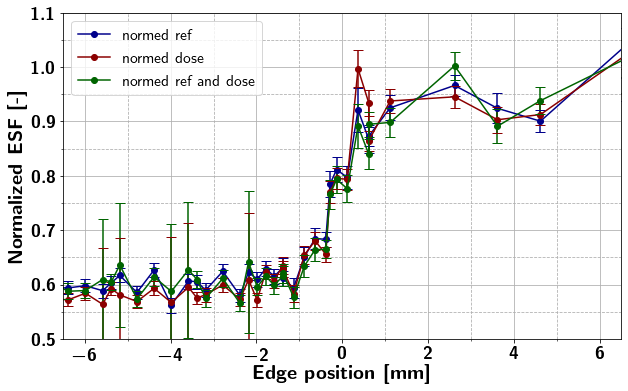

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
fs = 20

# normed with reference detector
X = data_scal['edge_pos'].values
Y = data_scal['ESS_cps_norm_REF'].values
Y_err =data_scal['ESS_cps_norm_REF_err'].values
color = 'darkblue'
lbl = 'normed ref'
plt.plot(X, Y, marker='o', color=color, label=lbl)
plt.errorbar(X, Y, xerr=None, yerr=Y_err, ls='none', color=color, capsize=5)

# normed with dose
X = data_scal['edge_pos'].values
Y = data_scal['ESS_cps_norm_dose'].values
Y_err =data_scal['ESS_cps_norm_dose_err'].values
color = 'darkred'
lbl = 'normed dose'
plt.plot(X, Y, marker='o', color=color, label=lbl)
plt.errorbar(X, Y, xerr=None, yerr=Y_err, ls='none', color=color, capsize=5)


# normed with ref and dose
X = data_scal['edge_pos'].values
Y = data_scal['ESS_cps_norm_REF_and_dose'].values
Y_err =data_scal['ESS_cps_norm_REF_and_dose_err'].values
color = 'darkgreen'
lbl = 'normed ref and dose'
plt.plot(X, Y, marker='o', color=color, label=lbl)
plt.errorbar(X, Y, xerr=None, yerr=Y_err, ls='none', color=color, capsize=5)



# minor ticks x
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
# tick font size
ax.tick_params('x', colors='black', labelsize=fs-2)	
ax.tick_params('y', colors='black', labelsize=fs-2)	
ax.set_ylabel(r'\textbf{Normalized ESF [-]}', fontsize=fs)
ax.set_xlabel(r'\textbf{Edge position [mm]}', fontsize=fs, labelpad=2)
ax.grid(b=True, which='major', linestyle='-')#, color='gray')
ax.grid(b=True, which='minor', linestyle='--')#, color='gray')
leg1 = plt.legend(loc="best",  fontsize=fs-4)

ax.set_xlim(-6.5, 6.5)
ax.set_xticks(np.arange(-6., 6+2, 2))
ax.set_ylim(0.5, 1.1)
plt.show()

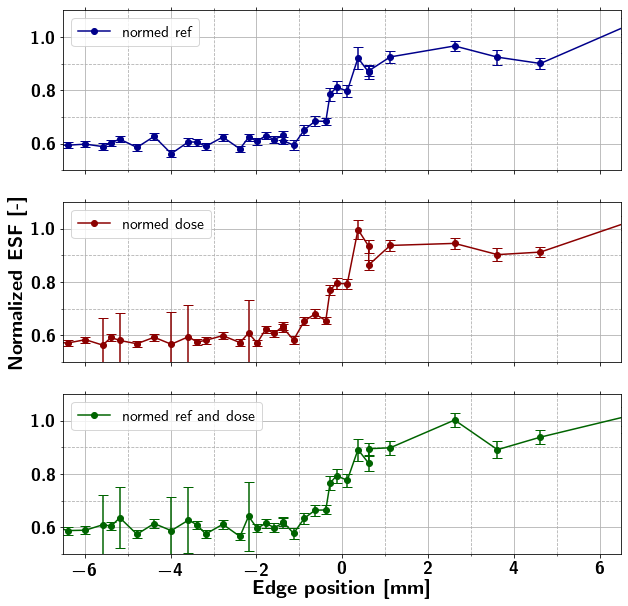

In [26]:
fig, axs = plt.subplots(3, 1, figsize=(10,10), sharex=True, sharey=True)
fs = 20
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

# normed with reference detector
X = data_scal['edge_pos'].values
Y = data_scal['ESS_cps_norm_REF'].values
Y_err =data_scal['ESS_cps_norm_REF_err'].values
color = 'darkblue'
lbl = 'normed ref'
ax1.plot(X, Y, marker='o', color=color, label=lbl)
ax1.errorbar(X, Y, xerr=None, yerr=Y_err, ls='none', color=color, capsize=5)
leg1 = ax1.legend(loc="best",  fontsize=fs-4)

# normed with dose
X = data_scal['edge_pos'].values
Y = data_scal['ESS_cps_norm_dose'].values
Y_err =data_scal['ESS_cps_norm_dose_err'].values
color = 'darkred'
lbl = 'normed dose'
# ax2 = ax1.twinx()
ax2.plot(X, Y, marker='o', color=color, label=lbl)
ax2.errorbar(X, Y, xerr=None, yerr=Y_err, ls='none', color=color, capsize=5)
leg2 = ax2.legend(loc="best",  fontsize=fs-4)


# normed with ref and dose
X = data_scal['edge_pos'].values
Y = data_scal['ESS_cps_norm_REF_and_dose'].values
Y_err =data_scal['ESS_cps_norm_REF_and_dose_err'].values
color = 'darkgreen'
lbl = 'normed ref and dose'
# ax3 = ax1.twinx()
ax3.plot(X, Y, marker='o', color=color, label=lbl)
ax3.errorbar(X, Y, xerr=None, yerr=Y_err, ls='none', color=color, capsize=5)
leg3 = ax3.legend(loc="best",  fontsize=fs-4)

# one liner to remove *all axes in all subplots*
# plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
# minor ticks x
for ax in axs:
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    # minor ticks y
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')#, color='gray')
    ax.grid(b=True, which='minor', linestyle='--')#, color='gray')

    ax.tick_params(axis='x',          # changes apply to the x-axis
                   which='both',      # both major and minor ticks are affected
                   bottom='off',      # ticks along the bottom edge are off
                   top='off',         # ticks along the top edge are off
                   labelbottom='off',  # labels along the bottom edge are off)
                   colors='black', 
                   labelsize=fs-2
                  )
    ax.tick_params(axis='y',          # changes apply to the x-axis
                   which='both',      # both major and minor ticks are affected
                   bottom='off',      # ticks along the bottom edge are off
                   top='off',         # ticks along the top edge are off
                   labelbottom='off',  # labels along the bottom edge are off)
                   colors='black', 
                   labelsize=fs-2
                  )

    ax3.set_xlim(-6.5, 6.5)
ax3.set_xticks(np.arange(-6., 6+2, 2))
ax3.set_ylim(0.5, 1.1)
ax2.set_ylabel(r'\textbf{Normalized ESF [-]}', fontsize=fs)
ax3.set_xlabel(r'\textbf{Edge position [mm]}', fontsize=fs, labelpad=2)

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
    
plt.show()

# Fit ESF

Resolution 10 to 90% is the x range in whicih the fit goes from 10 to 90 percent.

In [27]:
def get_esf_fit(x, y):
    """
    Computes the fit to the esf (logistic fit). Needs the x and y values. Returns the fit
    """
    def fitfunc(x, *p):
        a, b, c, d = p
        z = np.exp( -( (x-b)/(c) ) )
        # z = np.exp( -( (x-p[1])/(p[2]) ) )
        return (a / ( 1 + z )) + d
        # return (p[0] / ( 1 + z )) + p[3]
    m = [1e-2, 5e-2, 1e-1, 5e-1, 0, 1, 5, 1e1]
    p0 = [1,1,1,1]
    popt, pcov = curve_fit(fitfunc, x, y, p0=p0, maxfev=1000000)
    # print(popt)
    FWHM = 3.53*popt[2]  # 3.53 * c in fermi function
    # print(FWHM)
    X_fit = np.linspace(-10, 10, 1000)
    Y_fit = fitfunc(X_fit, *popt)
    
    return X_fit, Y_fit, FWHM

from sklearn.preprocessing import MinMaxScaler

def resolution_10_to_90_perc(X_fit, Y_fit):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = pd.DataFrame([X_fit, Y_fit]).T
    data.columns = ['X', 'Y']
    
    # norm by that
    data['Y_norm'] = scaler.fit_transform(data['Y'].values.astype(float).reshape(-1,1))
    
    # 10 and 90 percent level 
    x_10 = data.loc[data['Y_norm'] > 0.1].loc[:, 'X'].iloc[0]
    x_90 = data.loc[data['Y_norm'] > 0.9].loc[:, 'X'].iloc[0]
    
    return np.abs(x_90 - x_10)


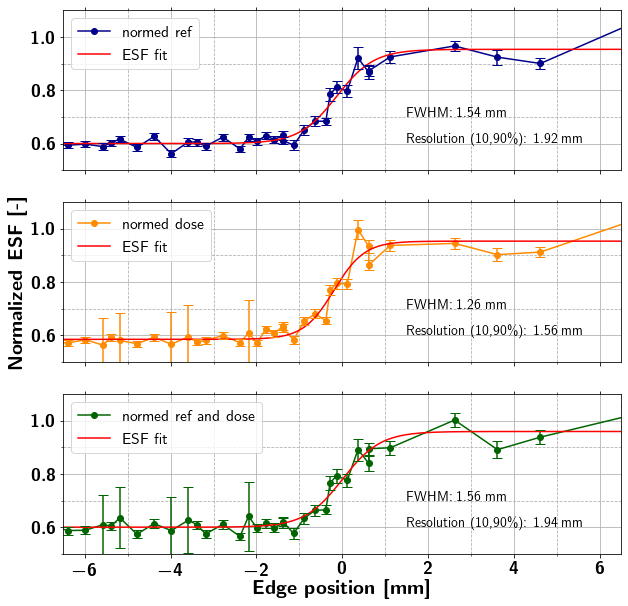

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(10,10), sharex=True, sharey=True)
fs = 20
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]
FWHMs = []
res_90_10s = []
text_x, text_y = (1.5, 0.7)
text_x_res, text_y_res = (1.5, 0.6)

# normed with reference detector
X = data_scal['edge_pos'].values.astype(float)
Y = data_scal['ESS_cps_norm_REF'].values.astype(float)
Y_err = data_scal['ESS_cps_norm_REF_err'].values.astype(float)
X_fit, Y_fit, FWHM = get_esf_fit(X, Y)
resolution_10_90 = resolution_10_to_90_perc(X_fit, Y_fit)
FWHMs.append(FWHM)
res_90_10s.append(resolution_10_90)
color = 'darkblue'
lbl = 'normed ref'
ax1.plot(X, Y, marker='o', color=color, label=lbl)
ax1.plot(X_fit, Y_fit, color='red', label='ESF fit')
ax1.text(text_x, text_y , f"FWHM: {FWHM:.2f} mm", fontsize=14)
ax1.text(text_x_res, text_y_res, f"Resolution (10,90\%): {resolution_10_90:.2f} mm", fontsize=14)
ax1.errorbar(X, Y, xerr=None, yerr=Y_err, ls='none', color=color, capsize=5)
leg1 = ax1.legend(loc="best",  fontsize=fs-4)

# normed with dose
X = data_scal['edge_pos'].values.astype(float)
Y = data_scal['ESS_cps_norm_dose'].values.astype(float)
Y_err = data_scal['ESS_cps_norm_dose_err'].values.astype(float)
X_fit, Y_fit, FWHM = get_esf_fit(X, Y)
resolution_10_90 = resolution_10_to_90_perc(X_fit, Y_fit)
FWHMs.append(FWHM)
res_90_10s.append(resolution_10_90)
color = 'darkorange'
lbl = 'normed dose'
# ax2 = ax1.twinx()
ax2.plot(X, Y, marker='o', color=color, label=lbl)
ax2.plot(X_fit, Y_fit, color='red', label='ESF fit')
ax2.text(text_x, text_y , f"FWHM: {FWHM:.2f} mm", fontsize=14)
ax2.text(text_x_res, text_y_res, f"Resolution (10,90\%): {resolution_10_90:.2f} mm", fontsize=14)
ax2.errorbar(X, Y, xerr=None, yerr=Y_err, ls='none', color=color, capsize=5)
leg2 = ax2.legend(loc="best",  fontsize=fs-4)


# normed with ref and dose
X = data_scal['edge_pos'].values.astype(float)
Y = data_scal['ESS_cps_norm_REF_and_dose'].values.astype(float)
Y_err = data_scal['ESS_cps_norm_REF_and_dose_err'].values.astype(float)
X_fit, Y_fit, FWHM = get_esf_fit(X, Y)
resolution_10_90 = resolution_10_to_90_perc(X_fit, Y_fit)
FWHMs.append(FWHM)
res_90_10s.append(resolution_10_90)
color = 'darkgreen'
lbl = 'normed ref and dose'
# ax3 = ax1.twinx()
ax3.plot(X, Y, marker='o', color=color, label=lbl)
ax3.plot(X_fit, Y_fit, color='red', label='ESF fit')
ax3.text(text_x, text_y , f"FWHM: {FWHM:.2f} mm", fontsize=14)
ax3.text(text_x_res, text_y_res, f"Resolution (10,90\%): {resolution_10_90:.2f} mm", fontsize=14)
ax3.errorbar(X, Y, xerr=None, yerr=Y_err, ls='none', color=color, capsize=5)
leg3 = ax3.legend(loc="best",  fontsize=fs-4)

# one liner to remove *all axes in all subplots*
# plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
# minor ticks x
for ax in axs:
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    # minor ticks y
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')#, color='gray')
    ax.grid(b=True, which='minor', linestyle='--')#, color='gray')

    ax.tick_params(axis='x',          # changes apply to the x-axis
                   which='both',      # both major and minor ticks are affected
                   bottom='off',      # ticks along the bottom edge are off
                   top='off',         # ticks along the top edge are off
                   labelbottom='off',  # labels along the bottom edge are off)
                   colors='black', 
                   labelsize=fs-2
                  )
    ax.tick_params(axis='y',          # changes apply to the x-axis
                   which='both',      # both major and minor ticks are affected
                   bottom='off',      # ticks along the bottom edge are off
                   top='off',         # ticks along the top edge are off
                   labelbottom='off',  # labels along the bottom edge are off)
                   colors='black', 
                   labelsize=fs-2
                  )

    ax3.set_xlim(-6.5, 6.5)
ax3.set_xticks(np.arange(-6., 6+2, 2))
ax3.set_ylim(0.5, 1.1)
ax2.set_ylabel(r'\textbf{Normalized ESF [-]}', fontsize=fs)
ax3.set_xlabel(r'\textbf{Edge position [mm]}', fontsize=fs, labelpad=2)

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
    
plt.show()

### Only ref normed

In [29]:
OUTPUTFOLDER = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/Emitting_Spot_Size'
FIGNAME = 'Emitting_Spot_Size'

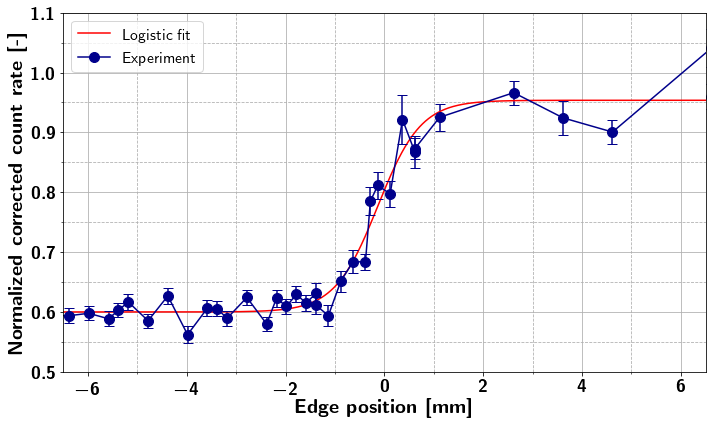

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
fs = 20

# normed with reference detector
X = data_scal['edge_pos'].values
Y = data_scal['ESS_cps_norm_REF'].values
Y_err =data_scal['ESS_cps_norm_REF_err'].values
X_fit, Y_fit, FWHM = get_esf_fit(X, Y)
resolution_10_90 = resolution_10_to_90_perc(X_fit, Y_fit)
FWHMs.append(FWHM)
res_90_10s.append(resolution_10_90)
color = 'darkblue'
ax.plot(X_fit, Y_fit, color='red', label='Logistic fit')
# ax.text(text_x, text_y , f"FWHM: {FWHM:.2f} mm", fontsize=fs-2, fontweight='bold')
# ax.text(text_x_res, text_y_res, f"Resolution (10,90\%): {resolution_10_90:.2f} mm", fontsize=14)
lbl = 'Experiment'
plt.plot(X, Y, marker='o', color=color, label=lbl, markersize=10)
plt.errorbar(X, Y, xerr=None, yerr=Y_err, ls='none', color=color, capsize=5)


# minor ticks x
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
# tick font size
ax.tick_params('x', colors='black', labelsize=fs-2)	
ax.tick_params('y', colors='black', labelsize=fs-2)	
ax.set_ylabel(r'\textbf{Normalized corrected count rate [-]}', fontsize=fs)
ax.set_xlabel(r'\textbf{Edge position [mm]}', fontsize=fs, labelpad=2)
ax.grid(b=True, which='major', linestyle='-')#, color='gray')
ax.grid(b=True, which='minor', linestyle='--')#, color='gray')
leg1 = plt.legend(loc="best",  fontsize=fs-4)

ax.set_xlim(-6.5, 6.5)
ax.set_xticks(np.arange(-6., 6+2, 2))
ax.set_ylim(0.5, 1.1)
plt.tight_layout()
plt.savefig(f"{OUTPUTFOLDER}/{FIGNAME}.pdf")
plt.show()

### FOR SNSF

In [31]:
OUTPUTFOLDER = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/Emitting_Spot_Size'
FIGNAME = 'Emitting_Spot_Size_SNSF'

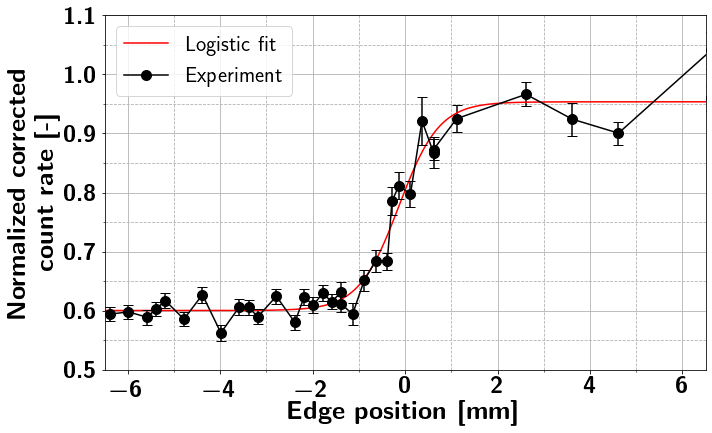

In [32]:
fig, ax = plt.subplots(figsize=(10,6))
fs = 26

# normed with reference detector
X = data_scal['edge_pos'].values
Y = data_scal['ESS_cps_norm_REF'].values
Y_err =data_scal['ESS_cps_norm_REF_err'].values
X_fit, Y_fit, FWHM = get_esf_fit(X, Y)
resolution_10_90 = resolution_10_to_90_perc(X_fit, Y_fit)
FWHMs.append(FWHM)
res_90_10s.append(resolution_10_90)
color = 'black'
ax.plot(X_fit, Y_fit, color='red', label='Logistic fit')
# ax.text(text_x, text_y , f"FWHM: {FWHM:.2f} mm", fontsize=fs-2, fontweight='bold')
# ax.text(text_x_res, text_y_res, f"Resolution (10,90\%): {resolution_10_90:.2f} mm", fontsize=14)
lbl = 'Experiment'
plt.plot(X, Y, marker='o', color=color, label=lbl, markersize=10)
plt.errorbar(X, Y, xerr=None, yerr=Y_err, ls='none', color=color, capsize=5)


# minor ticks x
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
# tick font size
ax.tick_params('x', colors='black', labelsize=fs-2)	
ax.tick_params('y', colors='black', labelsize=fs-2)	
ax.set_ylabel(r'\textbf{Normalized corrected}' + '\n' + r'\textbf{count rate [-]}', fontsize=fs)
ax.set_xlabel(r'\textbf{Edge position [mm]}', fontsize=fs, labelpad=2)
ax.grid(b=True, which='major', linestyle='-')#, color='gray')
ax.grid(b=True, which='minor', linestyle='--')#, color='gray')
leg1 = plt.legend(loc="best",  fontsize=fs-4)

ax.set_xlim(-6.5, 6.5)
ax.set_xticks(np.arange(-6., 6+2, 2))
ax.set_ylim(0.5, 1.1)
plt.tight_layout()
plt.savefig(f"{OUTPUTFOLDER}/{FIGNAME}.png", dpi=600)
plt.show()

In [37]:
def get_esf_fit(x, y):
    """
    Computes the fit to the esf (logistic fit). Needs the x and y values. Returns the fit
    """
    def fitfunc(x, *p):
        a, b, c, d = p
        z = np.exp( -( (x-b)/(c) ) )
        # z = np.exp( -( (x-p[1])/(p[2]) ) )
        return (a / ( 1 + z )) + d
        # return (p[0] / ( 1 + z )) + p[3]
    m = [1e-2, 5e-2, 1e-1, 5e-1, 0, 1, 5, 1e1]
    p0 = [1,1,1,1]
    popt, pcov = curve_fit(fitfunc, x, y, p0=p0, maxfev=1000000)
    # print(popt)
    FWHM = 3.53*popt[2]  # 3.53 * c in fermi function
    # print(FWHM)
    X_fit = np.linspace(-10, 10, 1000)
    Y_fit = fitfunc(X_fit, *popt)
    
    return X_fit, Y_fit, FWHM, popt

# Fit optimizer

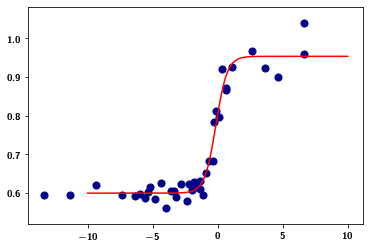

In [38]:
X_fit, Y_fit, FWHM, popt = get_esf_fit(X, Y)
plt.scatter(X, Y, color='darkblue', s=50)
plt.plot(X_fit, Y_fit, color='red', markersize=10)
plt.show()


In [41]:
def fitfunc(x, *p):
    a, b, c, d = p
    z = np.exp( -( (x-b)/(c) ) )
    # z = np.exp( -( (x-p[1])/(p[2]) ) )
    return (a / ( 1 + z )) + d
popt

array([ 1.        , -0.13477405,  0.43582884,  0.60008543])

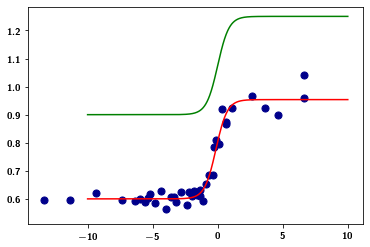

In [56]:
x = np.linspace(-10, 10, 1000)
popt = np.asarray([ 0.35, 0,  0.435,  0.9])
plt.scatter(X, Y, color='darkblue', s=50)
plt.plot(X_fit, Y_fit, color='red', markersize=10)
plt.plot(x, fitfunc(x, *popt), color='green', markersize=10)
plt.show()


In [77]:
np.random.normal(loc=np.std(Y), scale=np.std(Y))

0.4140730829391728

In [ ]:
# parameters of the logisti
# first parameter: y of the right side
# second parameter: zero pass through
# third parameter: slope
# fourth parameter: y of the left side

In [183]:
import numpy as np
from scipy import optimize as opt

def model(x, *p):
    """
    Logistic function with four parameters that are:
    # first parameter: y of the right side
    # second parameter: zero pass through
    # third parameter: slope
    # fourth parameter: y of the left side
    """
    a, b, c, d = p

    z = np.exp( -( (x-b)/(c) ) )

    return (a / ( 1 + z )) + d

def initial_guess(y):
    """
    For each of the parameters from the logistic fit function, make a guess for the value from a Normal distribution.
    Returns the guessed parameters
    """
    params = []
    # first parameter: y of the right side
    params.append(np.random.normal(loc=np.max(y), scale=np.std(y)))   
    # second parameter: zero pass through
    params.append(np.random.normal(loc=0, scale=np.std(y)))
    # third parameter: slope
    params.append(np.random.normal(loc=np.std(y), scale=np.std(y)))
    # fourth parameter: y of the left side
    params.append(np.random.normal(loc=np.min(y), scale=np.std(y)))  
    
    return np.asarray(params)

def split_data(x, y, train_size=0.8):
    """
    Split the data randomly into a train and test set.
    train_size: between 0 and 1 the fraction of the training set size
    """
    n_train = int(y.size * train_size)
    i_data = np.cumsum(np.ones(x.size), dtype=np.int) - 1
    i_train = np.sort(
        np.random.choice(i_data, size=n_train, replace=False))
    i_test = np.setdiff1d(i_data, i_train)
    X_train = np.asarray(x[i_train], dtype=np.float64)
    X_test = np.asarray(x[i_test], dtype=np.float64)
    y_train = np.asarray(y[i_train], dtype=np.float64)
    y_test = np.asarray(y[i_test], dtype=np.float64)

    return X_train, y_train, X_test, y_test

def loss_function(p, x_data, y_data, model):
    """
    Loss function is the total sum of squared differences between the data points (given as x_data, y_data and the predicted points.
    - p: model parameters
    - x_data, y_data: data points
    - model: function for the model (fit)
    """
    # predicted points

    y_pred = model(x_data, *p)

    loss = np.sum( (y_pred - y_data)**2 ) # total sum of squared differences

    return loss

def train(model, x_train, y_train, n_iter=3):
    p_best = None
    best_loss = 1e100
    for _ in range(n_iter):
        # The arguments that will get passed to the error function,
        # in addition to the model parameters of the current iteration.
        loss_fun_args = (x_train, y_train, model)
        p_initial = initial_guess(y=y_train)
        # Confusingly the `x0` argument is not expecting the x value of
        # the data points or for the 0th element of a list. It is for the
        # initial guess for the parameter values.
        res = opt.minimize(
            fun=loss_function,
            x0=p_initial,
            method="Nelder-Mead",
            args=loss_fun_args,
        )
        loss = loss_function(
            res.x,
            x_train,
            y_train,
            model,
        )
        if loss < best_loss:
            best_loss = loss
            p_best = res.x

    return p_best


def compare_models(x, y, train_size=0.8, n_folds=50, n_iter=3):

    data_sets = []
    for i_fold in range(n_folds):
        data_sets.append(split_data(x, y, train_size=0.8))

    all_training_errors = []
    all_testing_errors = []
    all_p_finals = []
    for i_fold in range(n_folds):
        x_train, y_train, x_test, y_test = data_sets[i_fold]

        p_final = train(model, x_train, y_train)

        all_training_errors.append(loss_function(
            p_final, x_train, y_train, model))
        all_testing_errors.append(loss_function(
            p_final, x_test, y_test, model))
        all_p_finals.append(p_final)

    return all_p_finals, all_training_errors, all_testing_errors



<ipython-input-183-bc0521d9a1bf>:14: RuntimeWarning: overflow encountered in exp
  z = np.exp( -( (x-b)/(c) ) )


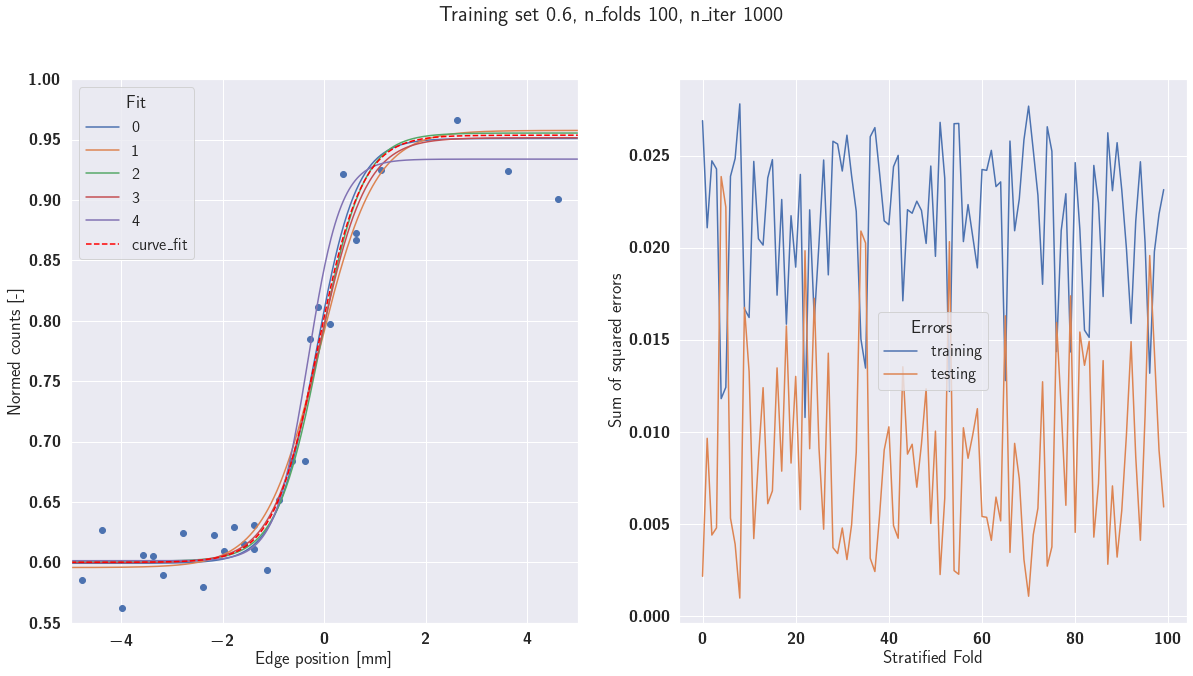

<ipython-input-183-bc0521d9a1bf>:14: RuntimeWarning: overflow encountered in exp
  z = np.exp( -( (x-b)/(c) ) )


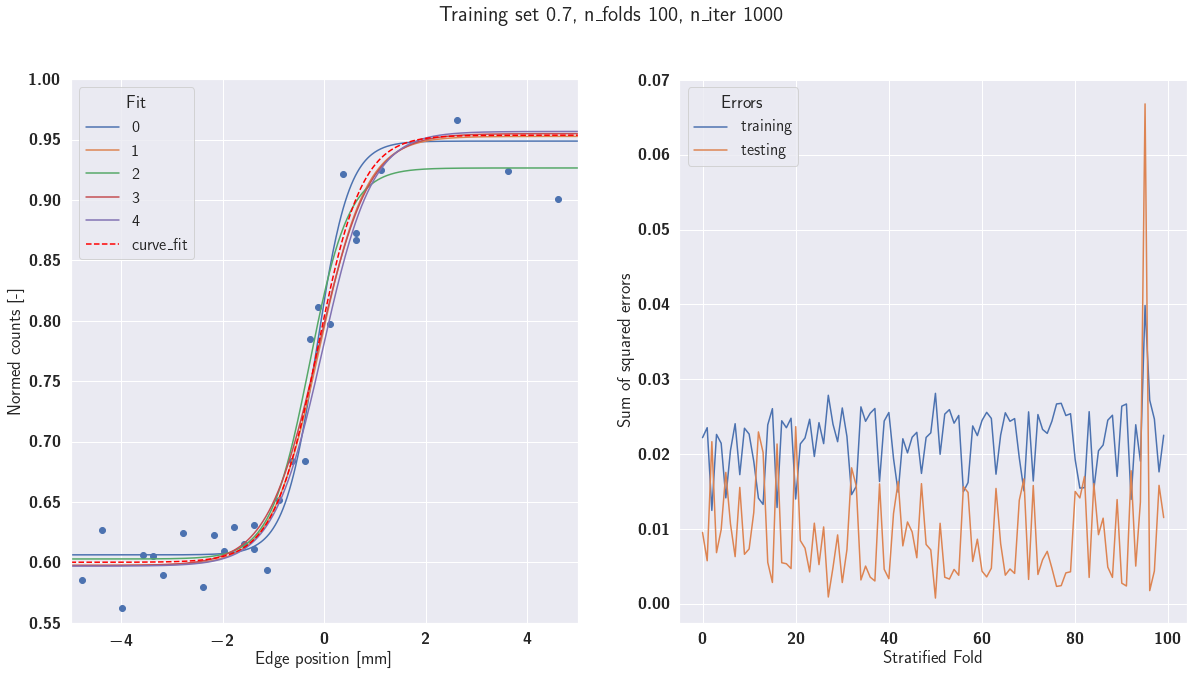

<ipython-input-183-bc0521d9a1bf>:14: RuntimeWarning: overflow encountered in exp
  z = np.exp( -( (x-b)/(c) ) )


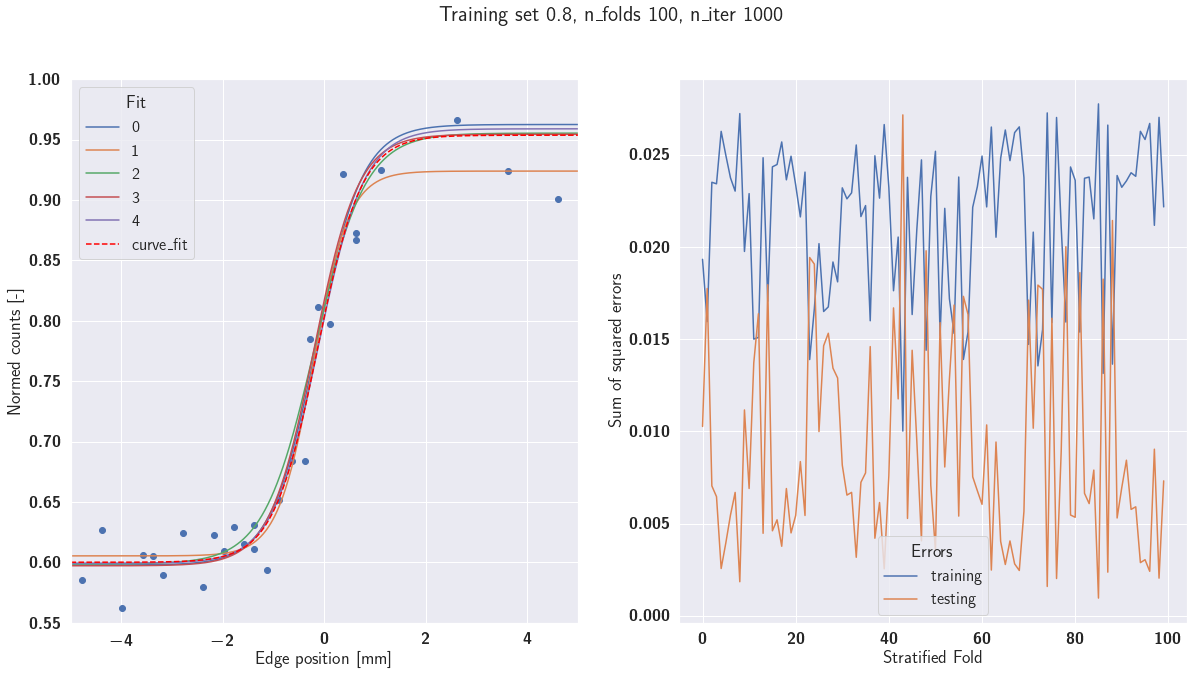

<ipython-input-183-bc0521d9a1bf>:14: RuntimeWarning: overflow encountered in exp
  z = np.exp( -( (x-b)/(c) ) )


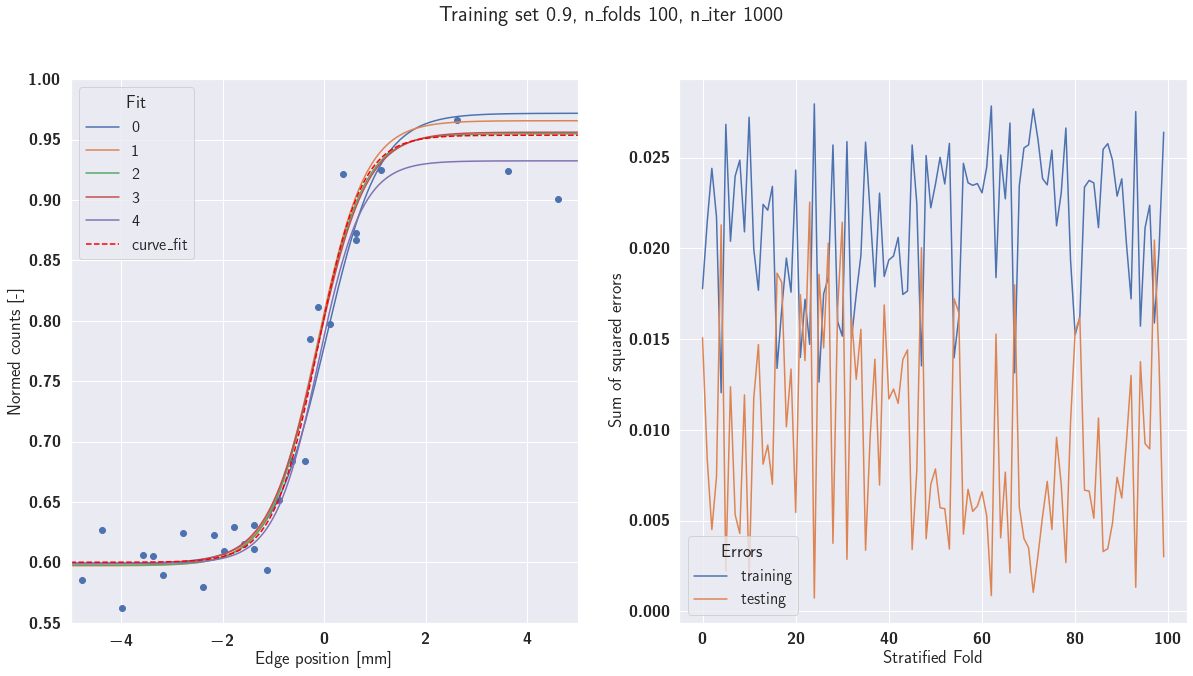

In [194]:
import seaborn as sns

train_sizes = [0.6, 0.7, 0.8, 0.9]
n_folds = 100
n_iter = 1000
FWHMs = []

for train_size in train_sizes:
    # p_finals, training_errors, testing_errors = compare_models(X, Y, train_size=0.8, n_folds=50, n_iter=50)
    p_finals, training_errors, testing_errors = compare_models(X, Y, train_size, n_folds, n_iter)
    p_finals_sample = p_finals[0:5]
    FWHMs.append(3.53 * np.abs( np.asarray(p_finals)[:,2]) )
    sns.set(font_scale=1.5, context='notebook')
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(f'Training set {train_size}, n\_folds {n_folds}, n\_iter {n_iter}')
    x = np.linspace(-10,10,1000)

    for ii, p in enumerate(p_finals_sample):
        Y_pred = model(x, *p)
        axs[0].plot(x, Y_pred, label=str(ii))

    axs[0].plot(X_fit, Y_fit, '--', color='red', label='curve\_fit')
    axs[0].scatter(X, Y)
    axs[0].set_xlim(-5, 5)
    axs[0].set_ylim(0.55, 1.0)
    axs[0].legend(title='Fit')
    axs[0].set_xlabel('Edge position [mm]')
    axs[0].set_ylabel('Normed counts [-]')

    axs[1].plot(training_errors, label='training')
    axs[1].plot(testing_errors, label='testing')
    axs[1].legend(title='Errors')
    axs[1].set_xlabel('Stratified Fold')
    axs[1].set_ylabel('Sum of squared errors')
    plt.show()

Training split 0.6: Mean: 1.54 mm, Std: 0.19 mm, Median: 1.54 mm.
Training split 0.7: Mean: 1.53 mm, Std: 0.24 mm, Median: 1.53 mm.
Training split 0.8: Mean: 1.52 mm, Std: 0.20 mm, Median: 1.52 mm.
Training split 0.9: Mean: 1.55 mm, Std: 0.20 mm, Median: 1.55 mm.


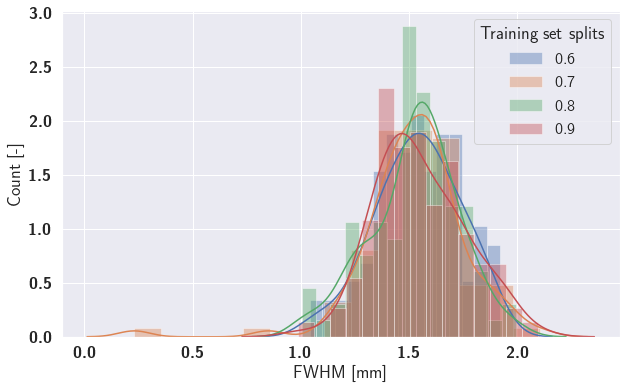

In [215]:
import scipy.stats as stats

fig, ax = plt.subplots(figsize=(10, 6))

for train_size, f in zip(train_sizes, FWHMs):
    sns.distplot(f, bins=15, ax=ax, label=train_size)
    print(f"Training split {train_size}: Mean: {np.mean(f):.2f} mm, Std: {np.std(f):.2f} mm, Median: {np.mean(f):.2f} mm.")
ax.set_xlabel('FWHM [mm]')
ax.set_ylabel('Count [-]')
ax.legend(title='Training set splits')
plt.show()

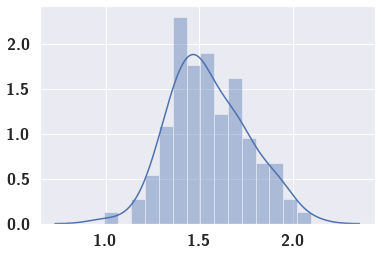

1.5502317522354718

In [222]:
sns.distplot(FWHMs[3], bins=15, label=train_size)
plt.show()
np.mean(FWHMs[3])